<a href="https://colab.research.google.com/github/wgova/time_series_trade/blob/master/notebooks/clustering_full_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q dtw-python
# dynamic time warping
from dtw import *
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import fcluster, ward, dendrogram

from scipy.cluster.vq import kmeans,vq
from math import sqrt
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler,StandardScaler,normalize
from sklearn.metrics.cluster import homogeneity_score
from sklearn import decomposition
from scipy.stats.mstats import winsorize
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import KMeans, SpectralClustering,DBSCAN 
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA

     |████████████████████████████████| 583kB 2.8MB/s 
Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



## Functions

In [ ]:
# Functions for dtw
def get_dtw_diff_matrix(df,cols:list):
    """
    From a list of series, compute a distance matrix by computing the 
    DTW distance of all pairwise combinations of series.
    """
    diff_matrix = {}
    cross = itertools.product(cols, cols)
    for (col1, col2) in cross:
        series1 = df[col1]
        series2 = df[col2]
        diff = dtw(
            series1, 
            series2,
            keep_internals=True, 
            step_pattern=rabinerJuangStepPattern(2, "c")
            )\
            .normalizedDistance
        diff_matrix[(col1, col2)] = [diff]
    return diff_matrix

def plot_dtw(df,series1:str, series2:str) -> None:
  dtw_df = dtw(df[series1],\
            df[series2],\
            keep_internals=True,
            step_pattern=rabinerJuangStepPattern(2, "c"))
  dtw_df.plot(type="twoway",offset=5)
  plt.savefig(f"DTW_{series1}_{series1}")
  plt.show()


# Data processing

In [ ]:
ref = 0
PATH = '/content/drive/My Drive/Stellenbosch/Webster'
path_to_parameter_eff_features = f'{PATH}/efficient_parameters'
path_to_parameter_comp_features = f'{PATH}/comprehensive_parameters'
list_files_min_feats = os.listdir(path_to_parameter_eff_features)
list_files_eff_features = os.listdir(path_to_parameter_eff_features)
scaled_data_location = f'{PATH}/mean_scaled_products/'
# files = os.listdir(min_feats)
data = list_files_eff_features[ref]
print(data)
product_name = 'engines_misc'

product_df = pd.read_csv(f'{path_to_parameter_eff_features}/{data}',index_col='id')#,parse_dates=['year'],index_col='year')
product_df_no_nulls = remove_null_values(product_df)
# print(check_outliers(uncorrelated_product_df))
product_df_no_outliers = removing_outliers(product_df_no_nulls)

In [ ]:
scaler = StandardScaler()
# scaler.fit_transform(uncorrelated_product_df_no_outliers)
product_scaled_uncorrelated = pd.DataFrame(scaler.fit_transform(features_uncorrelated),
                              columns = features_uncorrelated.columns,
                              index=features_uncorrelated.index)
len(product_scaled_uncorrelated.columns)

In [ ]:
#TODO: https://stats.stackexchange.com/questions/427327/simple-outlier-detection-for-time-series
random.seed(20)
random_countries = sample(list(features_uncorrelated.index),5)
product_excl_countries = features_uncorrelated[features_uncorrelated.index.isin(random_countries)]
product_by_countries = features_uncorrelated[features_uncorrelated.index.isin(random_countries)]
X_scaled_transposed = np.asarray(features_uncorrelated)
X_scaled_transposed.shape

fig = plt.figure(figsize=(16,5.5))
fig.add_subplot(121)
sns.heatmap(features_uncorrelated.corr(),annot=True)
# plt.title("Correlation between time series features")
plt.savefig(f"{PATH}/images/correlation_stats_features")

fig.add_subplot(122)
plt.plot(features_uncorrelated,label="Here")
# plt.title("Yarn fiber features for randomly picked \n countries excluding outliers")
plt.xticks(rotation=70)
plt.ylabel("Export value")
# plt.legend(features_uncorrelated.columns)
plt.show()

# Clustering

## Hierarchical clustering

<Figure size 720x396 with 0 Axes>

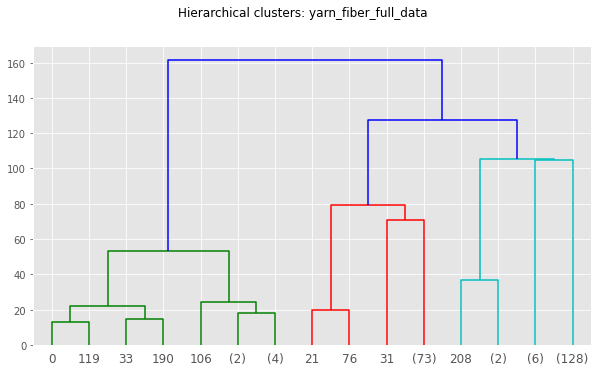

[1 2 6 4 3 5]


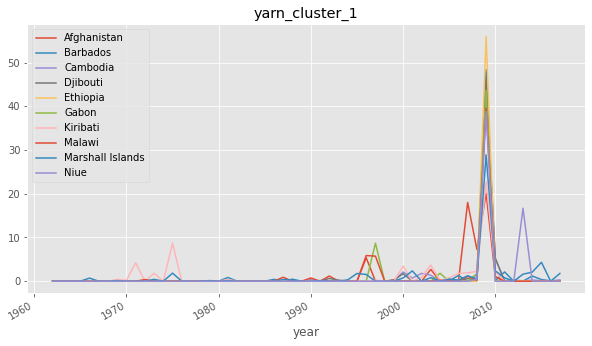

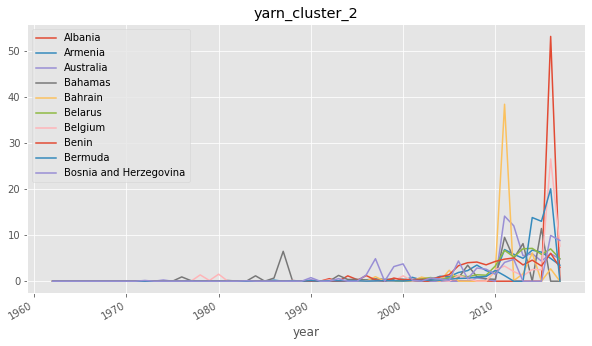

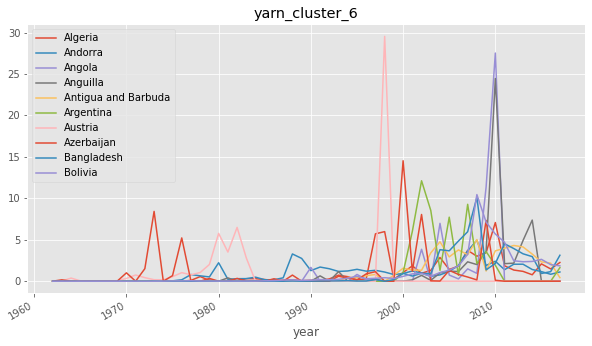

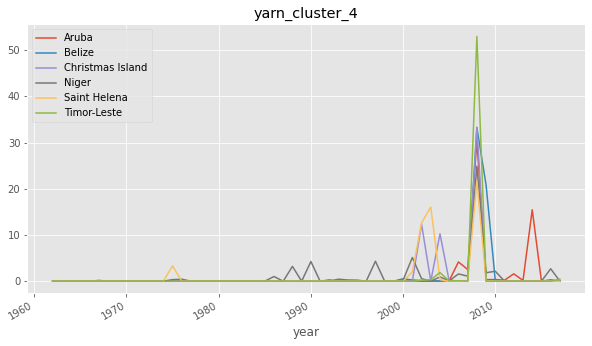

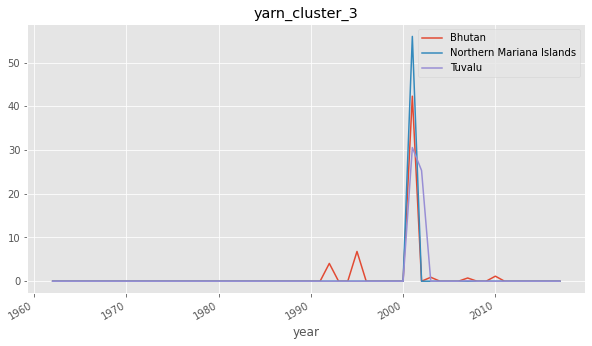

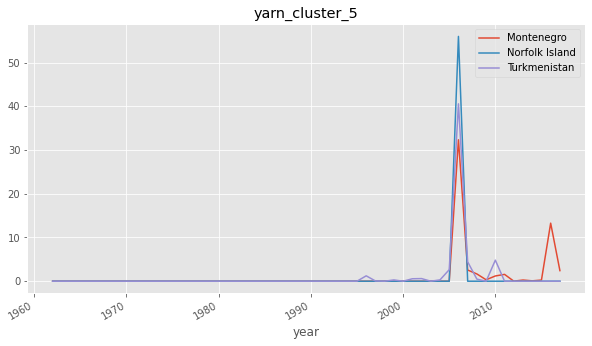

In [ ]:
# plot the top five levels of the dendrogram
plt.figure(figsize = (10,5.5))
linkage_matrix = plot_dendrogram(yarn_mean_scaled, "yarn_fiber_full_data",p=3, color_threshold = 110,truncate_mode='level')
plt.savefig("raw_data_hierarchical")
plt.show()
# extract clusters from dendogram
clusters = fcluster(linkage_matrix, 100, criterion='distance')
# create a lookup table for series in a given cluster
yarn_fiber_clusters = yarn_mean_scaled.T.reset_index()
yarn_fiber_clusters["cluster"] = clusters
yarn_fiber_clusters.rename(columns={'index':'country'},inplace=True)
yarn_fiber_clustered = yarn_fiber_clusters.set_index("cluster country".split())\
    .sort_index()

# cluster analysis
clusters = yarn_fiber_clusters.cluster.unique()
print(clusters)
for c in clusters:
  countries= yarn_fiber_clustered.loc[c].index.get_level_values(0).unique()
  # random.seed(1)
  n_samples = yarn_fiber_clustered.loc[c].shape[0]
  if n_samples > 10:
    n = random.sample(range(n_samples),10)
  else:
    n = range(n_samples)
  cluster = yarn_fiber_clustered.loc[c].T
  cluster.iloc[:, n].plot(subplots=False,figsize = (10,5.5),title=f"yarn_cluster_{c}")
  plt.legend(countries)
  plt.savefig(f"{PATH}/images/yarn_full_ts_cluster{c}")
  plt.show()

## Dynamic time warping

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:1450: UserWarning: Use the colorbar set_ticks() method instead.
  ax.set_yticks(self.tick_pos)


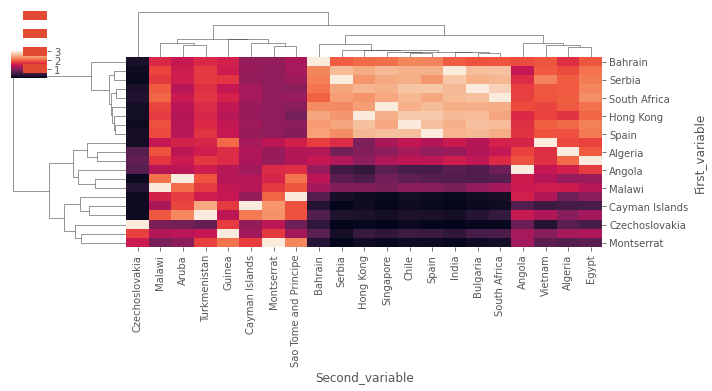

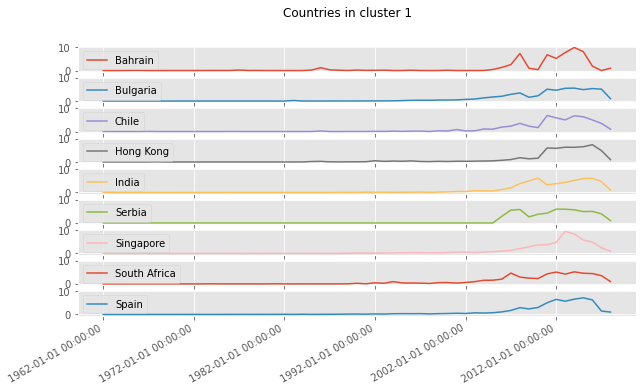

<Figure size 720x396 with 0 Axes>

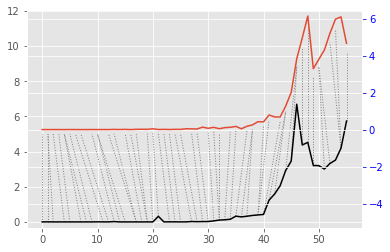

<Figure size 432x288 with 0 Axes>

DTW for Rwanda and Montenegro


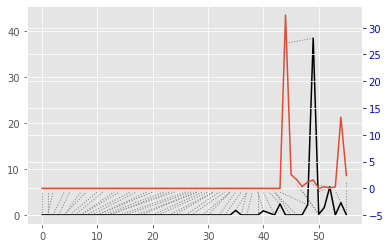

<Figure size 432x288 with 0 Axes>

DTW for Niger and Republic of the Congo


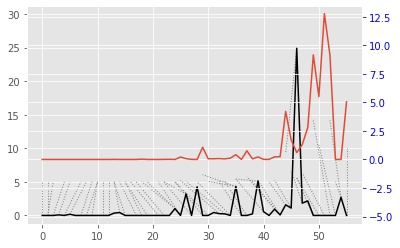

<Figure size 432x288 with 0 Axes>

In [ ]:
# sample 50 series, and compute the DTW distance matrix
random.seed(15)
sample_cols = random.sample(list(yarn_mean_scaled.columns), 20)
sample_cols.append('South Africa')
# sample_cols.extend(['South)
dtw_diff_dict = get_dtw_diff_matrix(yarn_mean_scaled,sample_cols)

# make into a df
dtw_diff_df = pd.DataFrame(dtw_diff_dict).T.reset_index()\
    .rename(columns = {"level_0":"First_variable", "level_1":"Second_variable", 0:"diff"})\
    .pivot_table(index = "First_variable", columns = "Second_variable", values = "diff")

# plot a similarity matrix, with a dendogram imposed
sns.clustermap(1-dtw_diff_df,figsize=(10,5.5))

# ward clustering from difference matrix, where distance is Dynamic time warping distance instead of Euclidean
time_warp = ward(dtw_diff_df)
# extract clusters
dtw_clusters = pd.DataFrame({"cluster":fcluster(time_warp, 1.15)}, index = dtw_diff_df.index)
dtw_clusters.cluster.value_counts().sort_index().plot.barh()
plt.title=("Frequency of DTW clusters")

# Check time series for any cluster
# TODO: Function to loop through all clusters and plot
# What cluster is South Africa? 
#print(dtw_clusters[dtw_clusters.index=='South Africa'])
cluster = 1
yarn_hc_clusters = yarn_mean_scaled.T.merge(
    dtw_clusters.loc[dtw_clusters.cluster ==cluster], 
    left_index = True,
    right_index = True)\
    .T
yarn_hc_clusters.plot(subplots=True,figsize = (10,5.5),sharey=True,title=f'Countries in cluster {cluster}')
plt.show()

fig = plt.figure(figsize=(10,5.5))
fig.suptitle(f'DTW : Examples')
# print('DTW for Turkey and India')
plot_dtw(yarn_mean_scaled,"Turkey", "India")
print('DTW for Rwanda and Montenegro')
plot_dtw(yarn_mean_scaled,"Rwanda", "Montenegro")
# fig.add_subplot(133)
print('DTW for Niger and Republic of the Congo')
plot_dtw(yarn_mean_scaled,"Niger", "Republic of the Congo")

In [ ]:
# https://www.dummies.com/programming/big-data/data-science/how-to-create-an-unsupervised-learning-model-with-dbscan/
dbscan = DBSCAN(eps=0.5, min_samples=5,metric='euclidean')
dbscan_results_yarn = dbscan.fit(X_scaled_transposed)
print(np.unique(dbscan.labels_))

# https://www.dummies.com/programming/big-data/data-science/how-to-create-an-unsupervised-learning-model-with-dbscan/
dbscan = DBSCAN(eps=0.5, min_samples=5,metric='euclidean')
dbscan.fit(X_scaled_transposed)
fig = plt.figure(figsize=(10,5.5))
fig.suptitle("Clusters for PCA-DBSCAN : yarn min_features", fontsize=16)
print(np.unique(dbscan.labels_))
fig.add_subplot(121)
# fig.set_title('Clusters')
pca = PCA(n_components=2)
pca_2d = pca.fit_transform(X_scaled_transposed)
for i in range(0, pca_2d.shape[0]):
  if dbscan.labels_[i] == 0:
    c1 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='r',marker='+')
  elif dbscan.labels_[i] == 1:
    c2 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='g',marker='o')
  elif dbscan.labels_[i] == 2:
    c3 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='b',marker='*')
  elif dbscan.labels_[i] == 3:
    c4 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='y',marker='x')
  elif dbscan.labels_[i] == 4:
    c5 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='g',marker='*')
  elif dbscan.labels_[i] == 5:
    c6 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='r',marker='x')
  elif dbscan.labels_[i] == -1:
    c7 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='c',marker='+')
plt.xlabel("Number of clusters_dbscan")
plt.legend([c1, c2, c3], ['Cluster 1', 
                                'Cluster 2',
                                'Cluster 3',
                                'Cluster 4',
                                'Cluster 5',
                                'Cluster 6',
                                'Noise'])

# plt.title('DBSCAN finds 2 clusters and noise')
fig.add_subplot(122)
# plt.set_title=("Cluster instances/frequency")
plt.hist(dbscan.labels_,bins=8)
plt.savefig(f"{PATH}/images/yarn_min_feats_pca_dbscan")
plt.show()